# Distance Metric Learning

To run each distance metric learning method, run all the cells in that section

## Utilities and Imports

In [2]:
from platform import python_version
print('Python Version: {}'.format( python_version() ) )

# Utils
from tqdm import tqdm_notebook # Progress bar

import numpy as np
import matplotlib.pyplot as plt

import json
from   scipy.io import loadmat

# sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.neighbors     import NearestNeighbors


Python Version: 3.6.7


In [1]:
# Constants
RANDOM_STATE = 42

## Data Manipulation

### Load Data

In [3]:
with open( "PR_data/feature_data.json", "r" ) as file:
    features = json.load( file )
    
data = np.asarray( features )

print( 'Data shape: {}'.format( data.shape ) )

# Load matfile
mat = loadmat( 'PR_data/cuhk03_new_protocol_config_labeled.mat' )

# Load labels
labels = mat[ 'labels' ].flatten()

# Load camId
camIds = mat[ 'camId' ].flatten()

# Load indexes
train_idxs   = mat[ 'train_idx' ].flatten()
query_idxs    = mat[ 'query_idx' ].flatten()
gallery_idxs = mat[ 'gallery_idx' ].flatten()

# Load training indexes
print( "Loading Training indexes : {}".format( train_idxs.shape ) )
print( "Loading Query indexes : {}".format( query_idxs.shape ) )
print( "Loading Gallery indexes : {}".format( gallery_idxs.shape ) )

Data shape: (14096, 2048)
Loading Training indexes : (7368,)
Loading Query indexes : (1400,)
Loading Gallery indexes : (5328,)


### Create Train/Query/Gallery Sets

In [4]:
def generateSets():
    # Create Train Set
    train_set   = []
    train_label = []

    for i in train_idxs:
        train_set.append( data[ i - 1 ] )
        train_label.append( labels[ i - 1 ] )

    train_set   = np.asarray( train_set )
    train_label = np.asarray( train_label )

    print( 'Train Set : {}'.format( train_set.shape ) )
    print( 'Train Label : {}'.format( train_label.shape ) ) 

    # Create Query Set
    query_set   = []
    query_label = []
    query_camId = []

    for i in query_idxs:
        query_set.append( data[ i - 1] )
        query_label.append( labels[ i - 1 ] )
        query_camId.append( camIds[ i - 1 ] )

    query_set   = np.asarray( query_set )
    query_label = np.asarray( query_label )
    query_camId = np.asarray( query_camId )

    print( '\nQuery Set : {}'.format( query_set.shape ) )
    print( 'Query Label : {}'.format( query_label.shape ) )
    print( 'Query CamId : {}'.format( query_camId.shape ) )


    # Create Gallery Set
    gallery_set   = []
    gallery_label = []
    gallery_camId = []

    for i in gallery_idxs:
        gallery_set.append( data[ i - 1] )
        gallery_label.append( labels[ i - 1 ] )
        gallery_camId.append( camIds[ i - 1 ] )

    gallery_set   = np.asarray( gallery_set )
    gallery_label = np.asarray( gallery_label )
    gallery_camId = np.asarray( gallery_camId )

    print( '\nGallery Set : {}'.format( gallery_set.shape ) )
    print( 'Gallery Label : {}'.format( gallery_label.shape ) )
    print( 'Gallery CamId : {}'.format( gallery_camId.shape ) )
    
    return train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId
    
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


### Validation

* Pick 100 random identites from the training set
* Remove all data with those 100 identities from training set and put in validation set

There exists an idea in Computer Vision that you use validation set only to specify the number of iterations that is optimal for your design and then you include your validation set into train set and perform final training (without validation set) for this fixed amount of iterations. 

In [6]:
from sklearn.utils import shuffle

train_unique_labels = np.unique( train_label )

# Select 100 Random Identities
shuffled_validation_labels = shuffle( train_unique_labels, random_state = RANDOM_STATE )[ : 100 ] 
print( 'Selecting *{}* Random Identities For Validation Set'.format( shuffled_validation_labels.shape[ 0 ] ) )

train_validate = np.zeros( ( 1, 2049 ) )
train_set_validate_removed = np.vstack( ( train_set.T, train_label ) ).T

for identity in tqdm_notebook( shuffled_validation_labels ):
    
    # Go through data and remove rows with that identity
    validation = train_set_validate_removed[ np.where( train_set_validate_removed[ :, -1 ] == identity ) ]
    
    train_validate = np.vstack( ( train_validate, validation ) )
    
    train_set_validate_removed = train_set_validate_removed[ np.where( train_set_validate_removed[ :, -1 ] != identity )]
    
print( 'Training Set with Validation removed: {}'.format( train_set_validate_removed.shape ) )
print( 'Validation Set: {} ( Has an extra row due to np.zeros )'.format( train_validate.shape ) )

Selecting *100* Random Identities For Validation Set



Training Set with Validation removed: (6399, 2049)
Validation Set: (970, 2049) ( Has an extra row due to np.zeros )


In [7]:
cv_train_set   = train_set_validate_removed.T[ : -1 ].T
cv_train_label = train_set_validate_removed.T[ -1 : ].T

cv_validation_set = train_validate.T[ : -1 ].T[ 1: ]
cv_validation_label = train_validate.T[ -1 : ].T[ 1 : ]

print( 'CV Train Set: {} \nTrain Labels: {}'.format( cv_train_set.shape, cv_train_label.shape ) )
print( 'CV Validation Set: {} \nValidation Labels: {}'.format( cv_validation_set.shape, cv_validation_label.shape ) )

CV Train Set: (6399, 2048) 
Train Labels: (6399, 1)
CV Validation Set: (969, 2048) 
Validation Labels: (969, 1)


___
## Mahalanobis

### Covariance Matrix

In [9]:
S2 = np.linalg.inv( np.dot( train_set.T, train_set ) )

w2, v2 = np.linalg.eig( S2 )

G2 = np.dot( np.diag( np.sqrt( w2 ) ), v2.T )

In [10]:
qs = np.dot( G2.T, query_set.T )
gs = np.dot( G2.T, gallery_set.T )

print( qs.shape )
print( gs.shape )

(2048, 1400)
(2048, 5328)


In [11]:
# Query Augmented


query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented


gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 2050)
Gallery Augmented: (5328, 2050)


In [12]:
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( n_neighbors = knn_n_neighbors, metric = knn_metric )
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [13]:
query_rank_list = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
            
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )

In [16]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt2  = query_rank_list.T[ : 2 ].T
rankAt3 = query_rank_list.T[ : 3 ].T
rankAt4  = query_rank_list.T[ : 4 ].T
rankAt5 = query_rank_list.T[ : 5 ].T
rankAt6  = query_rank_list.T[ : 6 ].T
rankAt7  = query_rank_list.T[ : 7 ].T
rankAt8 = query_rank_list.T[ : 8 ].T
rankAt9  = query_rank_list.T[ : 9 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc2  = np.sum( rankAt2, axis = 1 ) > 0 
cmc3  = np.sum( rankAt3, axis = 1 ) > 0 
cmc4  = np.sum( rankAt4, axis = 1 ) > 0 
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc6  = np.sum( rankAt6, axis = 1 ) > 0 
cmc7  = np.sum( rankAt7, axis = 1 ) > 0
cmc8  = np.sum( rankAt8, axis = 1 ) > 0 
cmc9  = np.sum( rankAt9, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

a11 = np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100
a21 = np.sum( cmc2 ) / cmc2.shape[ 0 ] * 100
a31 = np.sum( cmc3 ) / cmc3.shape[ 0 ] * 100
a41 = np.sum( cmc4 ) / cmc4.shape[ 0 ] * 100
a51 = np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100
a61 = np.sum( cmc6 ) / cmc6.shape[ 0 ] * 100
a71 = np.sum( cmc7 ) / cmc7.shape[ 0 ] * 100
a81 = np.sum( cmc8 ) / cmc8.shape[ 0 ] * 100
a91 = np.sum( cmc9 ) / cmc9.shape[ 0 ] * 100
a101 = np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@2: {}%'.format( np.sum( cmc2 ) / cmc2.shape[ 0 ] * 100 ) )
print( 'rank@3: {}%'.format( np.sum( cmc3 ) / cmc3.shape[ 0 ] * 100 ) )
print( 'rank@4: {}%'.format( np.sum( cmc4 ) / cmc4.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@6: {}%'.format( np.sum( cmc6 ) / cmc6.shape[ 0 ] * 100 ) )
print( 'rank@7: {}%'.format( np.sum( cmc7 ) / cmc7.shape[ 0 ] * 100 ) )
print( 'rank@8: {}%'.format( np.sum( cmc8 ) / cmc8.shape[ 0 ] * 100 ) )
print( 'rank@9: {}%'.format( np.sum( cmc9 ) / cmc9.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 46.57142857142857%
rank@2: 54.42857142857142%
rank@3: 59.21428571428572%
rank@4: 62.5%
rank@5: 65.64285714285715%
rank@6: 67.71428571428572%
rank@7: 69.71428571428572%
rank@8: 71.64285714285714%
rank@9: 73.35714285714286%
rank@10: 74.35714285714286%


___

## PCA

In [136]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [137]:
from sklearn.decomposition import PCA

PCA = PCA( n_components = 110, whiten = False )
PCA.fit( train_set )

PCA(copy=True, iterated_power='auto', n_components=110, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [138]:
pca_train_set = PCA.transform( train_set )
pca_gallery_set = PCA.transform( gallery_set )
pca_query_set = PCA.transform( query_set )

In [139]:
# Query Augmented
qs = pca_query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = pca_gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 112)
Gallery Augmented: (5328, 112)


In [140]:
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( algorithm = 'ball_tree',
                       n_neighbors = knn_n_neighbors,
                       metric = knn_metric )
                       
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [141]:
query_rank_list = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
            
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )

In [142]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt5  = query_rank_list.T[ : 5 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 46.64285714285714%
rank@5: 67.57142857142857%
rank@10: 74.85714285714286%


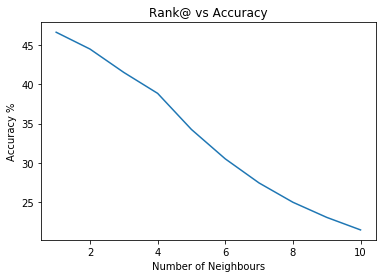

In [143]:
rank1Acc  = np.mean( np.mean( query_rank_list.T[ : 1 ], axis = 0 ) )
rank2Acc  = np.mean( np.mean( query_rank_list.T[ : 2 ], axis = 0 ) )
rank3Acc  = np.mean( np.mean( query_rank_list.T[ : 3 ], axis = 0 ) )
rank4Acc  = np.mean( np.mean( query_rank_list.T[ : 4 ], axis = 0 ) )
rank5Acc  = np.mean( np.mean( query_rank_list.T[ : 5 ], axis = 0 ) )
rank6Acc  = np.mean( np.mean( query_rank_list.T[ : 6 ], axis = 0 ) )
rank7Acc  = np.mean( np.mean( query_rank_list.T[ : 7 ], axis = 0 ) )
rank8Acc  = np.mean( np.mean( query_rank_list.T[ : 8 ], axis = 0 ) )
rank9Acc  = np.mean( np.mean( query_rank_list.T[ : 9 ], axis = 0 ) )
rank10Acc = np.mean( np.mean( query_rank_list.T[ : 10 ], axis = 0 ) )

Accuracies = [ rank1Acc, rank2Acc, rank3Acc, rank4Acc, rank5Acc, rank6Acc, rank7Acc, rank8Acc, rank9Acc, rank10Acc]
PCA_Accuracies = [ i * 100 for i in Accuracies ]

plt.plot( [ i for i in range( 1, 11 ) ], PCA_Accuracies )
plt.title( 'Rank@ vs Accuracy' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()

In [145]:
average_precision=[]
for i in tqdm_notebook(range(len(query_rank_list))):
    Precision=[]
    Recall=[]
    Total=sum(query_rank_list[i,:])
    for j in range(1,query_rank_list.shape[1]+1):
        Precision.append(sum(query_rank_list[i,:j]/j))
        Recall.append(sum(query_rank_list[i,:j]/Total))
        if Recall[j-1] == 1:
            break

    indices=[]
    Recall=np.array(Recall)
    Recall = np.nan_to_num(Recall)
    Precision=np.array(Precision)

    #re-map the recall and position to 0.1 ... 1.0
    recall = np.arange(0.1,1.1,0.1)
    recall = np.asarray(recall)
    precision=[]

    for j in range(recall.size):
        for i in range(len(Recall)):
            if Recall[i] >= recall[j]:
                #interprelation of the data, finding the map between now and future
                precision.append(max(Precision[Recall.tolist().index(Recall[i]):len(Precision)]))
                break
    if np.sum(precision) == 0:
        average_precision.append(0)
    else:
        average_precision.append((np.sum(precision)+precision[0])/11)

average_precision = np.nan_to_num(average_precision)
pca_map = np.mean(average_precision)
print( 'mAP: {}'.format( pca_map ) )

/home/aufar/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  



mAP: 0.5155136054421768


___

## Neighbourhood Component Analysis

In [146]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [147]:
from metric_learn import NCA

nca = NCA( max_iter = 100, verbose = True )
nca.fit( train_set, train_label )

[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         7.366959e+03      22.29
[NCA]          1         7.367001e+03      20.71
[NCA]          2         7.367999e+03      20.56
[NCA]          3         7.368000e+03      20.83
[NCA]          4         7.368000e+03      20.31
[NCA] Training took   108.52s.


NCA(learning_rate='deprecated', max_iter=100, num_dims=None, tol=None,
  verbose=True)

In [148]:
nca_train_set = nca.transform( train_set )
nca_gallery_set = nca.transform( gallery_set )
nca_query_set = nca.transform( query_set )

In [149]:
# Query Augmented
qs = nca_query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = nca_gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 2050)
Gallery Augmented: (5328, 2050)


In [150]:
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( algorithm = 'ball_tree',
                       n_neighbors = knn_n_neighbors,
                       metric = knn_metric )
                       
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [151]:
query_rank_list = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
            
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )

In [152]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt5  = query_rank_list.T[ : 5 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 44.642857142857146%
rank@5: 65.92857142857143%
rank@10: 73.85714285714286%


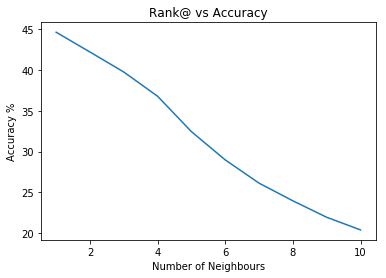

In [153]:
rank1Acc  = np.mean( np.mean( query_rank_list.T[ : 1 ], axis = 0 ) )
rank2Acc  = np.mean( np.mean( query_rank_list.T[ : 2 ], axis = 0 ) )
rank3Acc  = np.mean( np.mean( query_rank_list.T[ : 3 ], axis = 0 ) )
rank4Acc  = np.mean( np.mean( query_rank_list.T[ : 4 ], axis = 0 ) )
rank5Acc  = np.mean( np.mean( query_rank_list.T[ : 5 ], axis = 0 ) )
rank6Acc  = np.mean( np.mean( query_rank_list.T[ : 6 ], axis = 0 ) )
rank7Acc  = np.mean( np.mean( query_rank_list.T[ : 7 ], axis = 0 ) )
rank8Acc  = np.mean( np.mean( query_rank_list.T[ : 8 ], axis = 0 ) )
rank9Acc  = np.mean( np.mean( query_rank_list.T[ : 9 ], axis = 0 ) )
rank10Acc = np.mean( np.mean( query_rank_list.T[ : 10 ], axis = 0 ) )

NCA_Accuracies = [ rank1Acc, rank2Acc, rank3Acc, rank4Acc, rank5Acc, rank6Acc, rank7Acc, rank8Acc, rank9Acc, rank10Acc]
NCA_Accuracies = [ i * 100 for i in NCA_Accuracies ]

plt.plot( [ i for i in range( 1, 11 ) ], NCA_Accuracies )
plt.title( 'Rank@ vs Accuracy' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()

In [154]:
average_precision=[]
for i in tqdm_notebook(range(len(query_rank_list))):
    Precision=[]
    Recall=[]
    Total=sum(query_rank_list[i,:])
    for j in range(1,query_rank_list.shape[1]+1):
        Precision.append(sum(query_rank_list[i,:j]/j))
        Recall.append(sum(query_rank_list[i,:j]/Total))
        if Recall[j-1] == 1:
            break

    indices=[]
    Recall=np.array(Recall)
    Recall = np.nan_to_num(Recall)
    Precision=np.array(Precision)

    #re-map the recall and position to 0.1 ... 1.0
    recall = np.arange(0.1,1.1,0.1)
    recall = np.asarray(recall)
    precision=[]

    for j in range(recall.size):
        for i in range(len(Recall)):
            if Recall[i] >= recall[j]:
                #interprelation of the data, finding the map between now and future
                precision.append(max(Precision[Recall.tolist().index(Recall[i]):len(Precision)]))
                break
    if np.sum(precision) == 0:
        average_precision.append(0)
    else:
        average_precision.append((np.sum(precision)+precision[0])/11)

average_precision = np.nan_to_num(average_precision)
nca_map = np.mean(average_precision)
print( 'mAP: {}'.format( nca_map ) )

/home/aufar/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  



mAP: 0.49918972892187174


___
## Kernel PCA (Cosine)

In [155]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [156]:
from sklearn.decomposition import KernelPCA

KPCA = KernelPCA( n_components = 200, kernel = 'cosine' )
KPCA.fit( train_set )

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=200, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)

In [157]:
kpca_train_set = KPCA.transform( train_set )
kpca_gallery_set = KPCA.transform( gallery_set )
kpca_query_set = KPCA.transform( query_set )

In [158]:
# Query Augmented
qs = kpca_query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = kpca_gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 202)
Gallery Augmented: (5328, 202)


In [159]:
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( algorithm = 'ball_tree',
                       n_neighbors = knn_n_neighbors,
                       metric = knn_metric )
                       
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [160]:
query_rank_list = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
            
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )

In [161]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt5  = query_rank_list.T[ : 5 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 47.64285714285714%
rank@5: 67.35714285714286%
rank@10: 75.07142857142857%


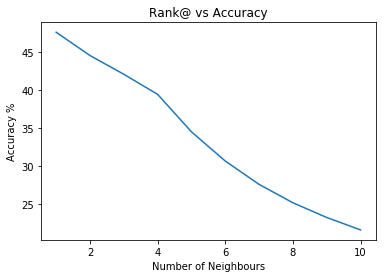

In [162]:
rank1Acc  = np.mean( np.mean( query_rank_list.T[ : 1 ], axis = 0 ) )
rank2Acc  = np.mean( np.mean( query_rank_list.T[ : 2 ], axis = 0 ) )
rank3Acc  = np.mean( np.mean( query_rank_list.T[ : 3 ], axis = 0 ) )
rank4Acc  = np.mean( np.mean( query_rank_list.T[ : 4 ], axis = 0 ) )
rank5Acc  = np.mean( np.mean( query_rank_list.T[ : 5 ], axis = 0 ) )
rank6Acc  = np.mean( np.mean( query_rank_list.T[ : 6 ], axis = 0 ) )
rank7Acc  = np.mean( np.mean( query_rank_list.T[ : 7 ], axis = 0 ) )
rank8Acc  = np.mean( np.mean( query_rank_list.T[ : 8 ], axis = 0 ) )
rank9Acc  = np.mean( np.mean( query_rank_list.T[ : 9 ], axis = 0 ) )
rank10Acc = np.mean( np.mean( query_rank_list.T[ : 10 ], axis = 0 ) )

KPCA_Accuracies = [ rank1Acc, rank2Acc, rank3Acc, rank4Acc, rank5Acc, rank6Acc, rank7Acc, rank8Acc, rank9Acc, rank10Acc]
KPCA_Accuracies = [ i * 100 for i in KPCA_Accuracies ]

plt.plot( [ i for i in range( 1, 11 ) ], KPCA_Accuracies )
plt.title( 'Rank@ vs Accuracy' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()

In [163]:
average_precision=[]
for i in tqdm_notebook(range(len(query_rank_list))):
    Precision=[]
    Recall=[]
    Total=sum(query_rank_list[i,:])
    for j in range(1,query_rank_list.shape[1]+1):
        Precision.append(sum(query_rank_list[i,:j]/j))
        Recall.append(sum(query_rank_list[i,:j]/Total))
        if Recall[j-1] == 1:
            break

    indices=[]
    Recall=np.array(Recall)
    Recall = np.nan_to_num(Recall)
    Precision=np.array(Precision)

    #re-map the recall and position to 0.1 ... 1.0
    recall = np.arange(0.1,1.1,0.1)
    recall = np.asarray(recall)
    precision=[]

    for j in range(recall.size):
        for i in range(len(Recall)):
            if Recall[i] >= recall[j]:
                #interprelation of the data, finding the map between now and future
                precision.append(max(Precision[Recall.tolist().index(Recall[i]):len(Precision)]))
                break
    if np.sum(precision) == 0:
        average_precision.append(0)
    else:
        average_precision.append((np.sum(precision)+precision[0])/11)

average_precision = np.nan_to_num(average_precision)
kpca_map = np.mean(average_precision)
print( 'mAP: {}'.format( kpca_map ) )

/home/aufar/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  



mAP: 0.5222346423417852


___
## Neighbourhood Component Analysis + KPCA

In [164]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [165]:
from sklearn.decomposition import KernelPCA

KPCA = KernelPCA( n_components = 200, kernel = 'cosine' )
KPCA.fit( train_set )

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=200, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)

In [166]:
kpca_train_set = KPCA.transform( train_set )
kpca_gallery_set = KPCA.transform( gallery_set )
kpca_query_set = KPCA.transform( query_set )

In [167]:
from metric_learn import NCA

nca = NCA( max_iter = 100, verbose = True )
nca.fit( kpca_train_set, train_label )

[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         2.868342e+03       6.31
[NCA]          1         3.606039e+03       6.34
[NCA]          2         6.374301e+03       6.31
[NCA]          3         7.358162e+03       6.34
[NCA]          4         7.358533e+03       6.35
[NCA]          5         7.359878e+03       6.33
[NCA]          6         7.364979e+03       6.32
[NCA]          7         7.367163e+03       6.35
[NCA]          8         7.367437e+03       6.31
[NCA]          9         7.367766e+03       6.48
[NCA]         10         7.367882e+03       6.37
[NCA]         11         7.367945e+03       6.38
[NCA]         12         7.367974e+03       6.73
[NCA]         13         7.367988e+03       6.39
[NCA]         14         7.367994e+03       6.37
[NCA]         15         7.367997e+03       7.38
[NCA]         16         7.367999e+03       6.75
[NCA]         17         7.367999e+03       6.30
[NCA]         

NCA(learning_rate='deprecated', max_iter=100, num_dims=None, tol=None,
  verbose=True)

In [168]:
nca_train_set = nca.transform( kpca_train_set )
nca_gallery_set = nca.transform( kpca_gallery_set )
nca_query_set = nca.transform( kpca_query_set )

In [169]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [170]:
# Query Augmented
qs = nca_query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = nca_gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 202)
Gallery Augmented: (5328, 202)


In [171]:
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( algorithm = 'ball_tree',
                       n_neighbors = knn_n_neighbors,
                       metric = knn_metric )
                       
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=None, n_neighbors=20, p=2, radius=1.0)

In [172]:
query_rank_list = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
            
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )

In [173]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt5  = query_rank_list.T[ : 5 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

rank@1: 45.92857142857143%
rank@5: 66.57142857142857%
rank@10: 74.78571428571429%


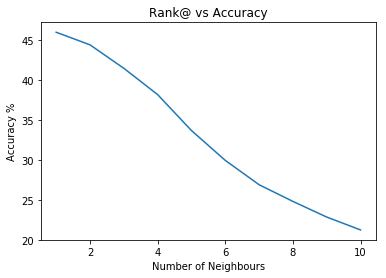

In [174]:
rank1Acc  = np.mean( np.mean( query_rank_list.T[ : 1 ], axis = 0 ) )
rank2Acc  = np.mean( np.mean( query_rank_list.T[ : 2 ], axis = 0 ) )
rank3Acc  = np.mean( np.mean( query_rank_list.T[ : 3 ], axis = 0 ) )
rank4Acc  = np.mean( np.mean( query_rank_list.T[ : 4 ], axis = 0 ) )
rank5Acc  = np.mean( np.mean( query_rank_list.T[ : 5 ], axis = 0 ) )
rank6Acc  = np.mean( np.mean( query_rank_list.T[ : 6 ], axis = 0 ) )
rank7Acc  = np.mean( np.mean( query_rank_list.T[ : 7 ], axis = 0 ) )
rank8Acc  = np.mean( np.mean( query_rank_list.T[ : 8 ], axis = 0 ) )
rank9Acc  = np.mean( np.mean( query_rank_list.T[ : 9 ], axis = 0 ) )
rank10Acc = np.mean( np.mean( query_rank_list.T[ : 10 ], axis = 0 ) )

KPCA_NCA_Accuracies = [ rank1Acc, rank2Acc, rank3Acc, rank4Acc, rank5Acc, rank6Acc, rank7Acc, rank8Acc, rank9Acc, rank10Acc]
KPCA_NCA_Accuracies = [ i * 100 for i in KPCA_NCA_Accuracies ]

plt.plot( [ i for i in range( 1, 11 ) ], KPCA_NCA_Accuracies )
plt.title( 'Rank@ vs Accuracy' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()

In [175]:
average_precision=[]
for i in tqdm_notebook(range(len(query_rank_list))):
    Precision=[]
    Recall=[]
    Total=sum(query_rank_list[i,:])
    for j in range(1,query_rank_list.shape[1]+1):
        Precision.append(sum(query_rank_list[i,:j]/j))
        Recall.append(sum(query_rank_list[i,:j]/Total))
        if Recall[j-1] == 1:
            break

    indices=[]
    Recall=np.array(Recall)
    Recall = np.nan_to_num(Recall)
    Precision=np.array(Precision)

    #re-map the recall and position to 0.1 ... 1.0
    recall = np.arange(0.1,1.1,0.1)
    recall = np.asarray(recall)
    precision=[]

    for j in range(recall.size):
        for i in range(len(Recall)):
            if Recall[i] >= recall[j]:
                #interprelation of the data, finding the map between now and future
                precision.append(max(Precision[Recall.tolist().index(Recall[i]):len(Precision)]))
                break
    if np.sum(precision) == 0:
        average_precision.append(0)
    else:
        average_precision.append((np.sum(precision)+precision[0])/11)

average_precision = np.nan_to_num(average_precision)
kpca_nca_map = np.mean(average_precision)
print( 'mAP: {}'.format( kpca_nca_map ) )


mAP: 0.510051638837353


/home/aufar/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Evaluation

### Method Comparisons

| Method | rank@1 | rank@5 | rank@10 |
| --- | --- | --- | --- |
Baseline | 47.0% | 66.85714285714286% | 74.92857142857143%
KPCA cosine ( 110 components )| 47.42857142857143% | 67.0% | 74.85714285714286%
KPCA cosine 200 | 47.64285714285714% | 67.35714285714286% | 75.07142857142857%
KPCA cosine 400 | 47.785714285714285% | 67.14285714285714% | 75.0%
KPCA cosine 1000 | 47.35714285714286% | 67.14285714285714% | 75.07142857142857%
NCA | 44.642857142857146% | 65.92857142857143% | 73.85714285714286%
KPCA cosine ( 100 ) + NCA | 45.42857142857143 | 66.21428571428571 | 75.35714285714286
kpca cosine 400 + NCA | 46.42857142857143% | 67.28571428571428% | 74.57142857142857%
kpca cosine 1000 + NCA | 43.642857142857146% | 63.714285714285715% | 71.5%



#### mAP Comparisons
* KPCA_NCA = 0.510051638837353
* KPCA = 0.5222346423417852
* NCA = 0.49918972892187174
* Baseline = 0.5169191146155432

In [129]:
Baseline_Accuracies = [47.0, 44.357142857142854, 41.61904761904761, 38.714285714285715, 
                       34.25714285714286, 30.511904761904756, 
                       27.448979591836732,24.982142857142858, 23.079365079365076, 21.47142857142857 ] 


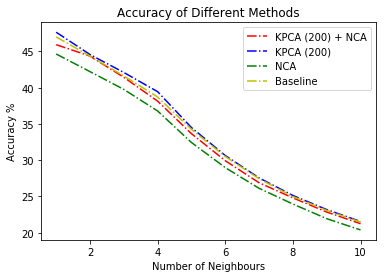

In [135]:
plt.plot( [ i for i in range( 1, 11 ) ], KPCA_NCA_Accuracies, 'r-.' )
plt.plot( [ i for i in range( 1, 11 ) ], KPCA_Accuracies, 'b-.' )
plt.plot( [ i for i in range( 1, 11 ) ], NCA_Accuracies, 'g-.' )
plt.plot( [ i for i in range( 1, 11 ) ], Baseline_Accuracies, 'y-.' )


plt.legend( [ 'KPCA (200) + NCA', 'KPCA (200)', 'NCA', 'Baseline' ] )

plt.title( 'Accuracy of Different Methods' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()